In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yt

batch = 3

# %matplotlib qt

### Parameter combinations

Models: `/mnt/research/SNAPhU/couch/run_mesa20_1dHyb`

3D data: `/mnt/research/SNAPhU/STIR/3dData`

In [23]:
params = []
    
if batch in (1, 2):
    al = (0.1, 0.2, 0.4, 0.8, 1.6)
    dint=(0.001, 0.002, 0.005, 0.01, 0.02)
    dtrb=(0.042, 0.083, 0.17, 0.33, 0.67)

    for i in al:
        for j in dint:
            for k in dtrb:
                params += [f'{i}_{j}_{k}']
                
elif batch == 3:            
    al = [1.0, 1.25]
    alv = [0.67, 1.0, 1.33]
    dtrb = [0.08, 0.17, 0.33]
#     dint = (0.001, 0.002, 0.004)
    dint = [0.001]
    dye = [0.001]
    dneut = [0.001]
    
    for i in al:
        for j in alv:
            for k in dtrb:
                for l in dint:
                    for m in dye:
                        for n in dneut:            
                            params += [f'{i}_{j}_{k}_{l}_{m}_{n}']    

print(f'{len(params)} param combinations')

18 param combinations


### Load 3D profiles

In [17]:
profile_3d = pd.read_csv('3d/mesa20_v_LR_avg.dat')

### Load STIR profiles

In [18]:
def load_cache():
    profiles = {}
    
    for v in params:
        profiles[v] = pd.read_csv(f'.temp/profile_batch_{batch}_{v}.csv')
    
    return profiles

In [19]:
def extract_profiles():
    profiles_raw = {}

    for v in params:
        if batch in (1, 2):
            fpath = f'stir/batch_{batch}/stir_mesa20_{v}_hdf5_chk_0002'
        elif batch == 3:
            fpath = f'stir/batch_{batch}/fitStir_{v}_hdf5_chk_0002'
            
        chk = yt.load(fpath).all_data()

        p = pd.DataFrame()
        p['r'] = chk['r']
        p['vcon'] = chk['vcon']

        p.to_csv(f'.temp/profile_batch_{batch}_{v}.csv')

        profiles_raw[v] = p    
    
    return profiles_raw

In [20]:
def interp(profiles_raw):
    profiles = {}
    r = np.array(profile_3d['r'])

    for v, p in profiles_raw.items():
        p2 = pd.DataFrame({'r': r})
        p2['vcon'] = np.interp(r, p['r'], p['vcon'])

        profiles[v] = p2
    
    return profiles

In [24]:
try:
    profiles_raw = load_cache()
except FileNotFoundError:
    profiles_raw = extract_profiles()

profiles = interp(profiles_raw)

yt : [INFO     ] 2023-08-21 18:29:30,686 Particle file found: fitStir_1.0_0.67_0.08_0.001_0.001_0.001_hdf5_chk_0002
yt : [WARNING  ] 2023-08-21 18:29:30,699 Extending phi dimension to 2PI + left edge.
yt : [WARNING  ] 2023-08-21 18:29:30,699 Extending theta dimension to PI + left edge.
yt : [INFO     ] 2023-08-21 18:29:30,753 Parameters: current_time              = 0.13500096396218525
yt : [INFO     ] 2023-08-21 18:29:30,754 Parameters: domain_dimensions         = [240   1   1]
yt : [INFO     ] 2023-08-21 18:29:30,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-21 18:29:30,755 Parameters: domain_right_edge         = [1.50000000e+09 3.14159265e+00 6.28318531e+00]
yt : [INFO     ] 2023-08-21 18:29:30,756 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-08-21 18:29:30,955 Particle file found: fitStir_1.0_0.67_0.17_0.001_0.001_0.001_hdf5_chk_0002
yt : [WARNING  ] 2023-08-21 18:29:30,961 Extending phi dimension to 2PI + left edge.
yt : [WARNING

yt : [INFO     ] 2023-08-21 18:29:33,248 Parameters: domain_dimensions         = [240   1   1]
yt : [INFO     ] 2023-08-21 18:29:33,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-21 18:29:33,249 Parameters: domain_right_edge         = [1.50000000e+09 3.14159265e+00 6.28318531e+00]
yt : [INFO     ] 2023-08-21 18:29:33,249 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2023-08-21 18:29:33,442 Particle file found: fitStir_1.25_0.67_0.33_0.001_0.001_0.001_hdf5_chk_0002
yt : [WARNING  ] 2023-08-21 18:29:33,448 Extending phi dimension to 2PI + left edge.
yt : [WARNING  ] 2023-08-21 18:29:33,448 Extending theta dimension to PI + left edge.
yt : [INFO     ] 2023-08-21 18:29:33,476 Parameters: current_time              = 0.13500096396218525
yt : [INFO     ] 2023-08-21 18:29:33,477 Parameters: domain_dimensions         = [240   1   1]
yt : [INFO     ] 2023-08-21 18:29:33,478 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-08-2

### Calculate fits

In [25]:
l1 = []
l2 = []

for v, p in profiles.items():
    diff = p['vcon'] - profile_3d['vcon']
    l1 += [np.linalg.norm(diff, 1)]
    l2 += [np.linalg.norm(diff, 2)]
    
results = pd.DataFrame({'params': params, 
                        'l1': l1, 
                        'l2': l2})

In [26]:
mins = results.min()

min_l1 = results.iloc[results.l1.idxmin()]['params']
min_l2 = results.iloc[results.l2.idxmin()]['params']

profile_l1 = profiles[min_l1]
profile_l2 = profiles[min_l2]

### Plot

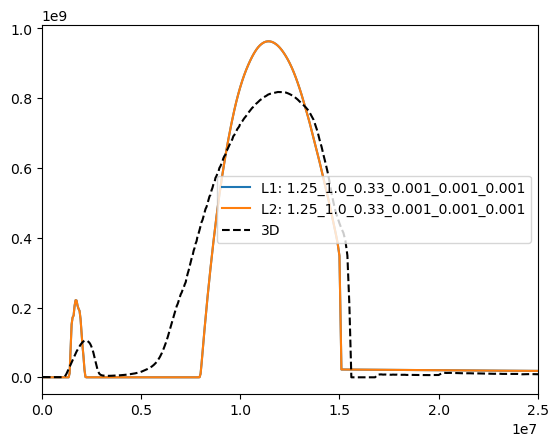

In [30]:
fig, ax = plt.subplots()

ax.set_xlim([0, 2.5e7])

ax.plot(profile_l1['r'], profile_l1['vcon'], label=f'L1: {min_l1}')
ax.plot(profile_l2['r'], profile_l2['vcon'], label=f'L2: {min_l2}')

ax.plot(profile_3d['r'], profile_3d['vcon'], ls='--', c='k', label='3D')

ax.legend()
fig.savefig(f'plots/vcon_best_batch_{batch}.png')

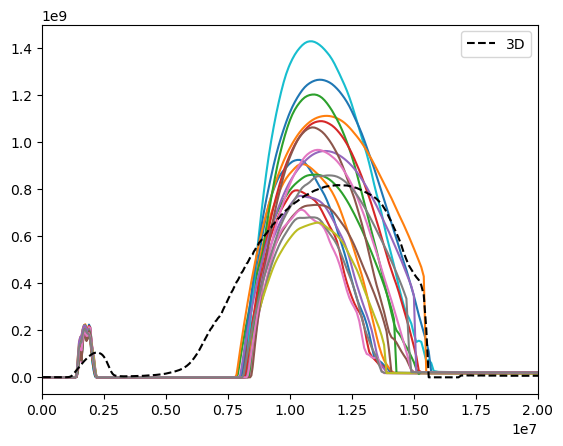

In [31]:
fig, ax = plt.subplots()

ax.set_xlim([0, 2e7])

for p in profiles.values():
    ax.plot(p['r'], p['vcon'])

ax.plot(profile_3d['r'], profile_3d['vcon'], ls='--', c='k', label='3D')
    
ax.legend()
fig.savefig(f'plots/vcon_all_batch_{batch}.png')